# 0. Setup

Reference: 
https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import os
import datetime

import IPython
import IPython.display

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

2023-01-05 13:05:33.908694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Dataset

In [2]:
csv_path = 'delhi_data/'

In [3]:
original_train_df = pd.read_csv(os.path.join(csv_path,r'DailyDelhiClimateTrain.csv'))
test_df = pd.read_csv(os.path.join(csv_path,r'DailyDelhiClimateTest.csv'))

In [4]:
original_train_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


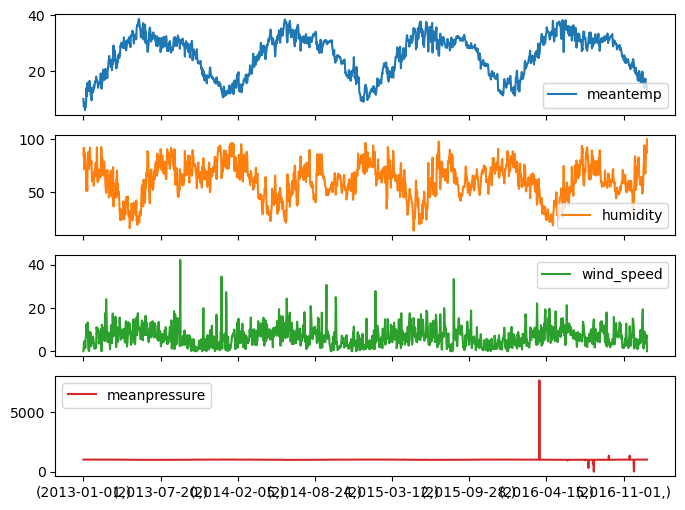

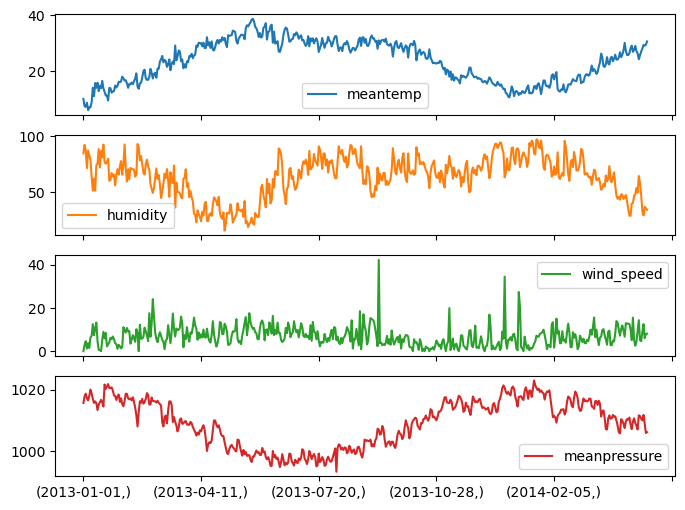

In [5]:
plot_cols = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
plot_features = original_train_df[plot_cols]
plot_features.index = original_train_df[['date']]
_ = plot_features.plot(subplots=True)

plot_features = original_train_df[plot_cols][:480]
plot_features.index = original_train_df[['date']][:480]
_ = plot_features.plot(subplots=True)

## 1-1. Inspect and cleanup

In [6]:
original_train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1011.104548,180.231668,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333


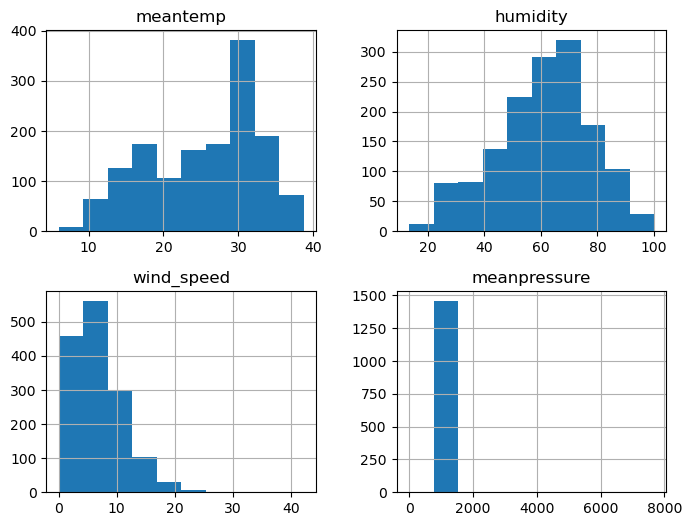

In [7]:
# 
original_train_df.hist()
plt.show()

There are weird values in 'meanpressure', which are likely erroneous.

In [8]:
avg_pressure = np.average(original_train_df[['meanpressure']])

mean_pressure = original_train_df['meanpressure']
minus_pressure = mean_pressure < 0
mean_pressure[minus_pressure] = avg_pressure


large_pressure = mean_pressure >= 2000
mean_pressure[large_pressure] = avg_pressure

/var/folders/61/rqxnvzd54cn2vyyxhg42gs5r0000gn/T/ipykernel_1788/1879460503.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_pressure[minus_pressure] = avg_pressure
/var/folders/61/rqxnvzd54cn2vyyxhg42gs5r0000gn/T/ipykernel_1788/1879460503.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_pressure[large_pressure] = avg_pressure


In [9]:
original_train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1007.237186,36.465060,12.045455,1001.611607,1008.571429,1014.921875,1352.615385


## 1-2. Feature engineering

In [10]:
original_train_df.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [11]:
original_train_df = original_train_df.drop(columns=['date'])

## 1-3. Split the data

In [12]:
print(f'train: {original_train_df.shape}')
print(f'test: {test_df.shape}')

train: (1462, 4)
test: (114, 5)


 - trainig sets: 80% of original_train_df
 - validation sets: 20% of original_train_df

In [13]:
column_indices = {name: i for i, name in enumerate(original_train_df.columns)}

n = len(original_train_df)
train_df = original_train_df[0:int(n*0.8)]
val_df = original_train_df[int(n*0.8):int(n)]

num_features = original_train_df.shape[1]

In [14]:
print(f'train: {train_df.shape}')
print(f'val: {val_df.shape}')
print(f'test: {test_df.shape}')

train: (1169, 4)
val: (293, 4)
test: (114, 5)


## 1-4. Normalize the data

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

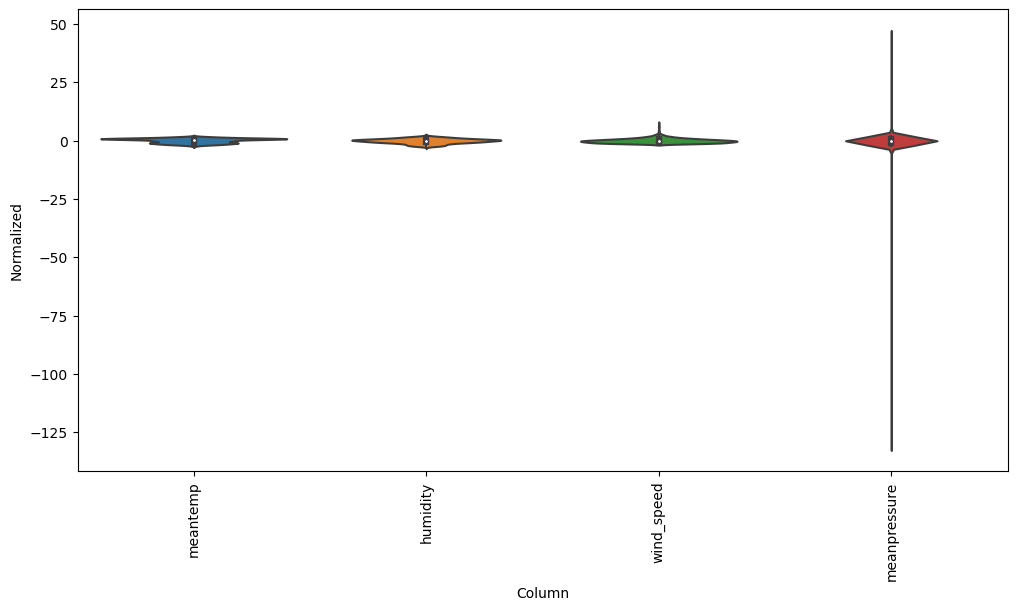

In [16]:
df_std = (original_train_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(original_train_df.keys(), rotation=90)

# 2. Data Windowing

## 2-1. Indexes and offsets

In [17]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [18]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['meantemp'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['meantemp']

In [19]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['meantemp'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['meantemp']

## 2-2. Split

In [20]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [21]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 4)
Inputs shape: (3, 6, 4)
Labels shape: (3, 1, 1)


2023-01-05 13:05:58.252010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2-3. Plot

In [22]:
w2.example = example_inputs, example_labels

In [23]:
def plot(self, model=None, plot_col='meantemp', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

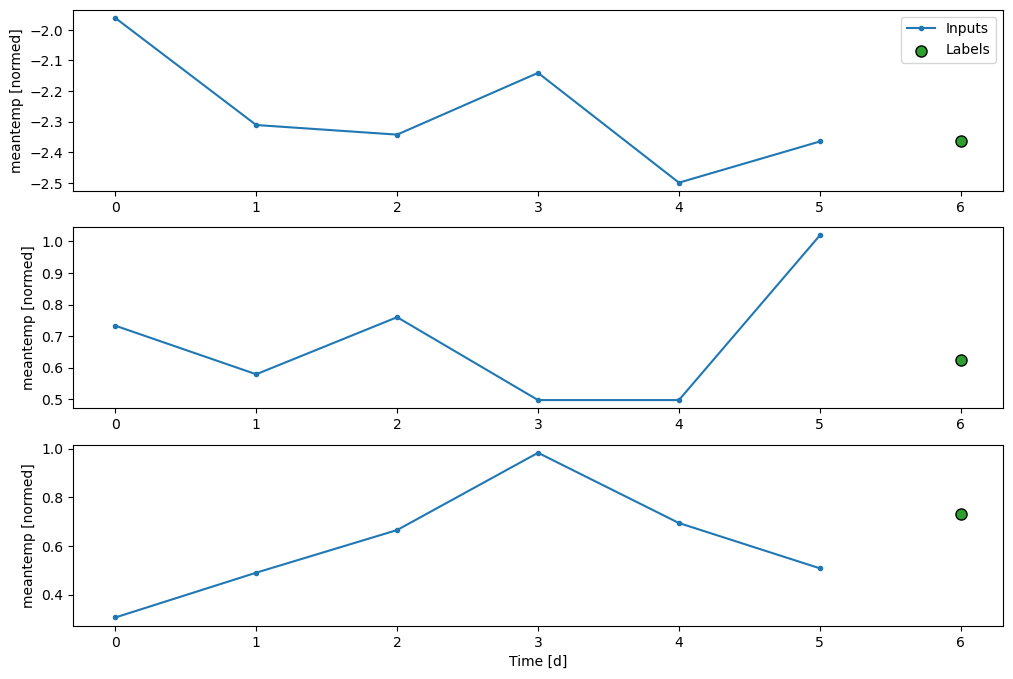

In [24]:
w2.plot()

## 2-4. Create tf.data.Datasets

In [25]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [26]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [27]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [28]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 4)
Labels shape (batch, time, features): (32, 1, 1)


# 3. Single step models

In [29]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['meantemp'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['meantemp']

In [30]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 4)
Labels shape (batch, time, features): (32, 1, 1)


## 3-1. Baseline

In [31]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [32]:
baseline = Baseline(label_index=column_indices['meantemp'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

10/10 [==============================] - 0s 3ms/step - loss: 0.0515 - mean_absolute_error: 0.1694


### Wide window

In [33]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['meantemp'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['meantemp']

In [34]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 4)
Output shape: (32, 24, 1)


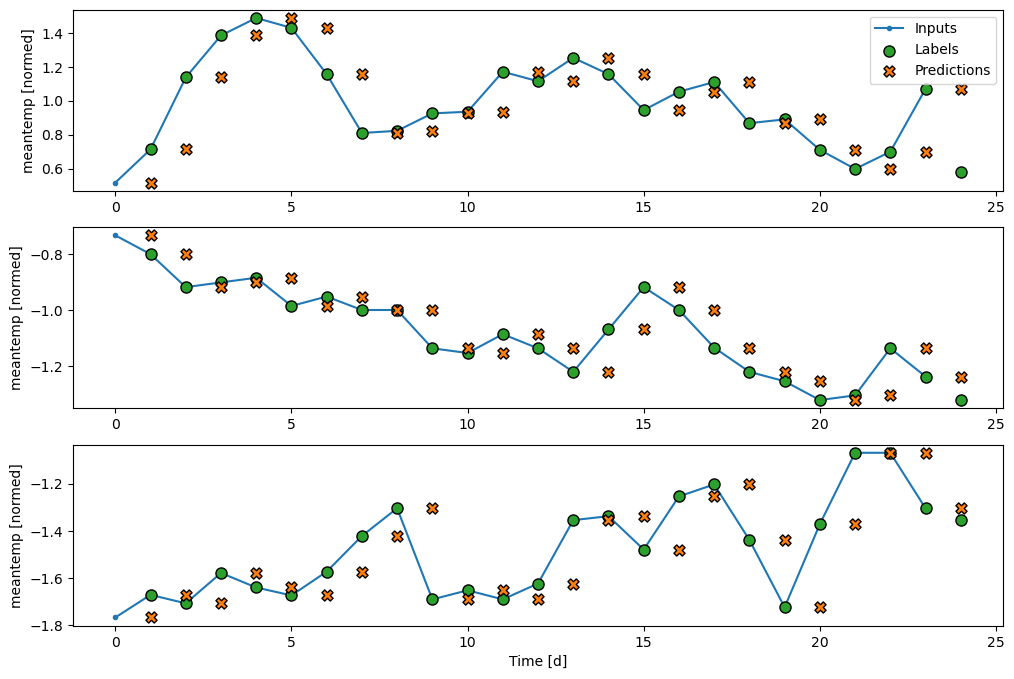

In [35]:
wide_window.plot(baseline)

## 3-2. Linear Model

- Insert linear transformation between the input and output.

In [36]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])


In [37]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 4)
Output shape: (32, 1, 1)


- Package the training procedure into a fuction

In [38]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [39]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)


Epoch 1/20
37/37 [==============================] - 1s 20ms/step - loss: 1.9348 - mean_absolute_error: 1.2257 - val_loss: 5.7936 - val_mean_absolute_error: 1.4606
Epoch 2/20
37/37 [==============================] - 0s 5ms/step - loss: 1.7125 - mean_absolute_error: 1.1502 - val_loss: 7.1861 - val_mean_absolute_error: 1.4337
Epoch 3/20
10/10 [==============================] - 0s 2ms/step - loss: 8.8168 - mean_absolute_error: 1.4138


In [40]:
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/dense/Tensordot/MatMul' defined at (most recent call last):
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once
      handle._run()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 530, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/61/rqxnvzd54cn2vyyxhg42gs5r0000gn/T/ipykernel_1788/976859712.py", line 1, in <module>
      performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/layers/core/dense.py", line 244, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'sequential/dense/Tensordot/MatMul'
Matrix size-incompatible: In[0]: [32,5], In[1]: [4,1]
	 [[{{node sequential/dense/Tensordot/MatMul}}]] [Op:__inference_test_function_3068]

In [118]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 4)
Output shape: (32, 24, 1)


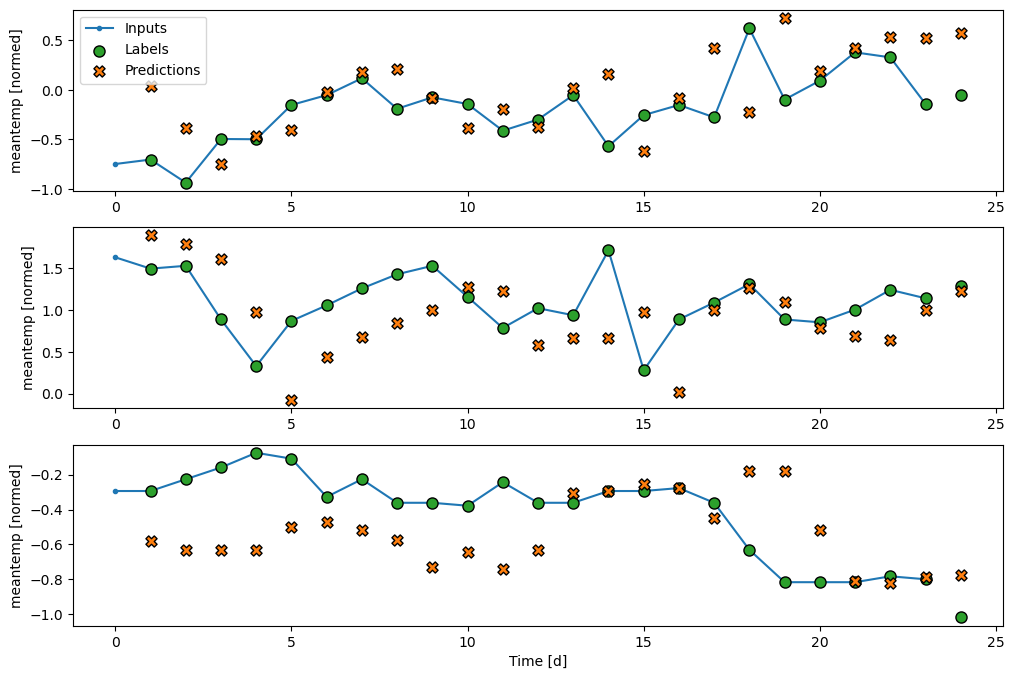

In [119]:
wide_window.plot(linear)

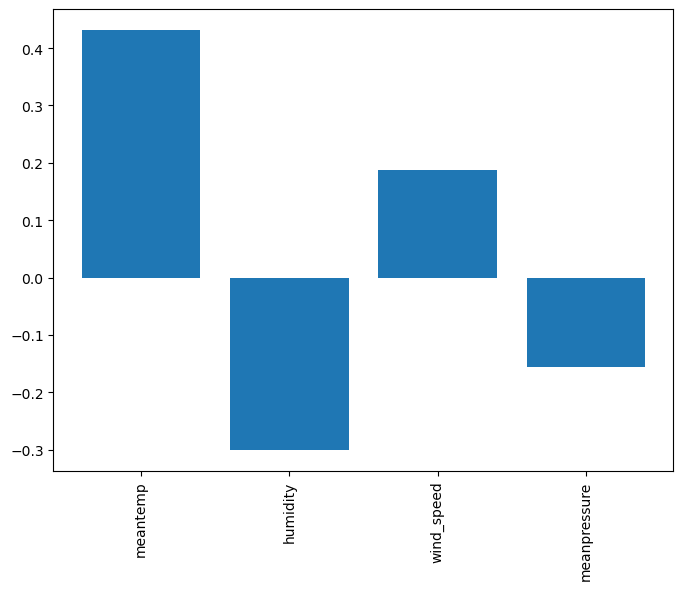

In [120]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## 3-3. Dense

In [121]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
37/37 [==============================] - 3s 25ms/step - loss: 0.3142 - mean_absolute_error: 0.3961 - val_loss: 20.7728 - val_mean_absolute_error: 0.8383
Epoch 2/20
37/37 [==============================] - 1s 12ms/step - loss: 0.0739 - mean_absolute_error: 0.2137 - val_loss: 9.1599 - val_mean_absolute_error: 0.5852
Epoch 3/20
37/37 [==============================] - 0s 10ms/step - loss: 0.0556 - mean_absolute_error: 0.1824 - val_loss: 5.2321 - val_mean_absolute_error: 0.4707
Epoch 4/20
37/37 [==============================] - 0s 8ms/step - loss: 0.0504 - mean_absolute_error: 0.1723 - val_loss: 3.6915 - val_mean_absolute_error: 0.3944
Epoch 5/20
37/37 [==============================] - 0s 11ms/step - loss: 0.0486 - mean_absolute_error: 0.1686 - val_loss: 3.0327 - val_mean_absolute_error: 0.3718
Epoch 6/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0482 - mean_absolute_error: 0.1663 - val_loss: 3.0348 - val_mean_absolute_error: 0.3581
Epoch 7/20
37/37 [=====

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/dense_1/Tensordot/MatMul' defined at (most recent call last):
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once
      handle._run()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 530, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/61/rqxnvzd54cn2vyyxhg42gs5r0000gn/T/ipykernel_3116/380085211.py", line 10, in <module>
      performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/layers/core/dense.py", line 244, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'sequential_1/dense_1/Tensordot/MatMul'
Matrix size-incompatible: In[0]: [32,5], In[1]: [4,64]
	 [[{{node sequential_1/dense_1/Tensordot/MatMul}}]] [Op:__inference_test_function_13777]

## 3-4. Multi-step dense

In [132]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['meantemp'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['meantemp']

Text(0.5, 1.0, 'Given 3 days of inputs, predict 1 day into the future.')

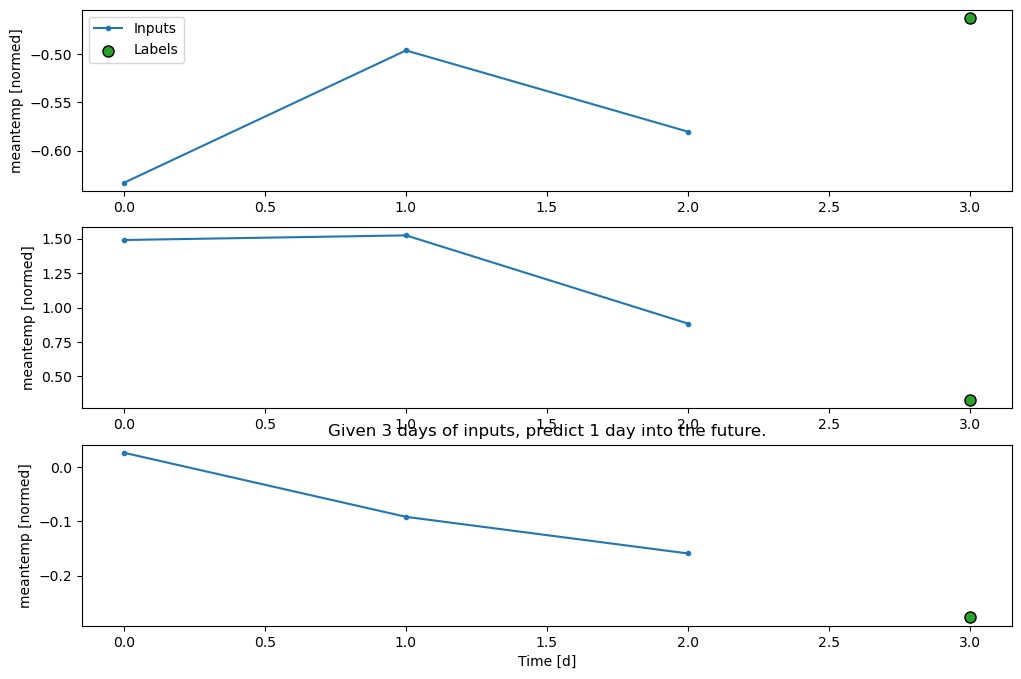

In [134]:
conv_window.plot()
plt.title("Given 3 days of inputs, predict 1 day into the future.")

In [135]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [136]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 4)
Output shape: (32, 1, 1)


In [139]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
# performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
37/37 [==============================] - 2s 20ms/step - loss: 0.0477 - mean_absolute_error: 0.1699 - val_loss: 6.7515 - val_mean_absolute_error: 0.6684
Epoch 2/20
37/37 [==============================] - 1s 15ms/step - loss: 0.0461 - mean_absolute_error: 0.1669 - val_loss: 6.9977 - val_mean_absolute_error: 0.6780
Epoch 3/20
10/10 [==============================] - 0s 17ms/step - loss: 7.6330 - mean_absolute_error: 0.6874


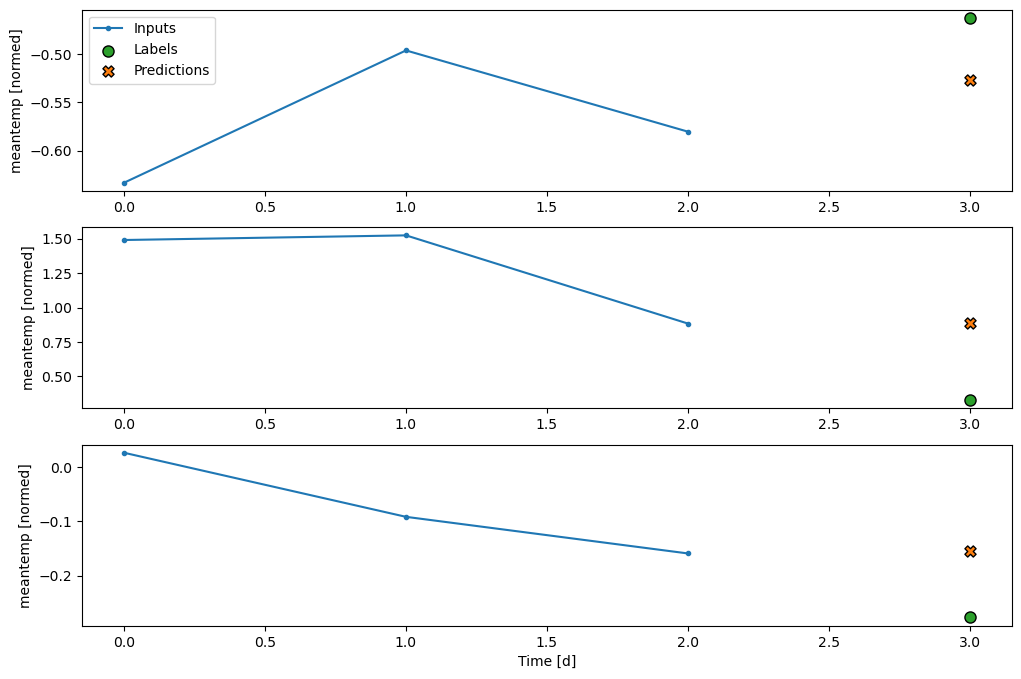

In [140]:
conv_window.plot(multi_step_dense)

## 3-5. Convolution neural network

In [141]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [142]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 4)
Output shape: (32, 1, 1)


In [145]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

10/10 [==============================] - 0s 3ms/step - loss: 1.4776 - mean_absolute_error: 0.3955


2023-01-04 17:28:24.152528: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at conv_ops_fused_impl.h:720 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 5 vs 4


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_4/conv1d/Conv1D' defined at (most recent call last):
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once
      handle._run()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 530, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/61/rqxnvzd54cn2vyyxhg42gs5r0000gn/T/ipykernel_3116/701978211.py", line 5, in <module>
      performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/Users/morishitamizuki/opt/anaconda3/envs/self_projects/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_4/conv1d/Conv1D'
input depth must be evenly divisible by filter depth: 5 vs 4
	 [[{{node sequential_4/conv1d/Conv1D}}]] [Op:__inference_test_function_30565]

## 3-6. Recurrent neural network

## 3-7. Performance

## 3-8. Multi-output models

# 4. Multi-step models

## 4-1. Baselines

## 4-2. Single-shot models

## 4-3. Advanced: Autoregressive model

## 4-4. Peroformance